In [1]:
from easydict import EasyDict as edict
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from generate_data_test_without_blank_depth import input_fn_maker
import FLAGS_tf2
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
from PIL import Image
from generate_network import generate_network as model_fn
from IPython import display

1 Physical GPUs, 1 Logical GPU


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
test_config = tf.ConfigProto(device_count = {'GPU': 0}, allow_soft_placement=True, log_device_placement=True)
test_config.gpu_options.allow_growth = True 

In [3]:
flags = FLAGS_tf2.flags
# eps = 0.3
eps = [0, 0.1, 0.2, 0.3]
loss_type = 'CEP'   # 'CEP' or 'paper'
if loss_type == 'CEP':
    from generate_network import generate_network as model_fn
if loss_type == 'paper':    
    from generate_network_other_loss import generate_network as model_fn

logit_type = 'normal'

In [4]:
test_file = flags.path.test_file
print(test_file)
test_data_list=[test_file]
eval_input_fn = lambda: input_fn_maker(test_data_list, shuffle=False, batch_size = 1, epoch=1)
data = input_fn_maker(test_data_list, shuffle=False, batch_size = 1, epoch=1)

['/mnt/sdb1/mike/Datasets/OULU-NPU/mtcnn/Test_features', '/mnt/sdb1/mike/Datasets/OULU-NPU/Test_Depth_all']


In [5]:
checkpoint_path = '/mnt/sdb1/zhuweilun/FAS-SGTD/OULU-NPU_4/model.ckpt-100001'
# print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=True)

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [7]:
this_config=tf.estimator.RunConfig(
    save_summary_steps=10000000000,
    save_checkpoints_steps=None,
    keep_checkpoint_max=1024,
    log_step_count_steps=None,
    session_config=config)

In [8]:
model_fn_this = model_fn
inference_model_dir = '/mnt/sdb1/zhuweilun/FAS-SGTD/OULU-NPU_4/'
mnist_classifier = tf.estimator.Estimator(model_fn=model_fn_this, config=this_config, model_dir=inference_model_dir)
save_path = "/mnt/sdb1/zhuweilun/FAS-SGTD/saved_model/"

INFO:tensorflow:Using config: {'_model_dir': '/mnt/sdb1/zhuweilun/FAS-SGTD/OULU-NPU_4/', '_tf_random_seed': None, '_save_summary_steps': 10000000000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': None, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 1024, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
feature_spec = {"images": tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 15], name='images'),
               "maps": tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 5], name='maps'),
               "masks": tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 15], name='masks'),
               "labels": tf.placeholder(dtype=tf.int32, shape=[None, 1], name='labels'),
               "names": tf.placeholder(dtype=tf.int32, shape=[1], name='names')}

In [10]:
input_receiver_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_spec)

export_model_path = mnist_classifier.export_savedmodel(save_path, input_receiver_fn)
export_model_path = export_model_path.decode()

Instructions for updating:
This function has been renamed, use `export_saved_model` instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Calling model_fn.
(None, 1)
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.Flatten instead.
loss_cla  Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(None,), dtype=float32)
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensor

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    images_np = data["images"].eval()

Dataset Info:
----------------------------------------
IJCB ijcb_protocal_4 test
File Counts: 40
----------------------------------------


In [12]:
features = mnist_classifier.predict(input_fn = eval_input_fn, checkpoint_path = checkpoint_path)
features_list = list(features)

INFO:tensorflow:Calling model_fn.
(None, 1)
loss_cla  Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(None,), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /mnt/sdb1/zhuweilun/FAS-SGTD/OULU-NPU_4/model.ckpt-100001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Dataset Info:
----------------------------------------
IJCB ijcb_protocal_4 test
File Counts: 40
----------------------------------------


In [13]:
# n_attack_success = 0
# n_test_real = 0
# if not os.path.exists('FGSM_result'):
#     os.makedirs('FGSM_result')

In [14]:
# dataset = flags.path.dataset
# print(dataset)

In [15]:
# if  dataset == 'OULU-NPU':
#     result_path = os.path.join('FGSM_result', dataset, flags.dataset.protocal, f'logit_type_{logit_type}', f'loss_type_{loss_type}', f'eps_{eps}')
# else:
#     result_path = os.path.join('FGSM_result', dataset, f'logit_type_{logit_type}', f'loss_type_{loss_type}', f'eps_{eps}')
    
# if not os.path.exists(result_path):
#     os.makedirs(result_path)

In [16]:
if flags.paras.inverse:
    label_spoof = 1
    label_real = 0
else:
    label_spoof = 0
    label_real = 1

In [17]:
def show(frames):
    _squeeze = np.squeeze(frames)
    _frames = np.split(_squeeze, indices_or_sections=5, axis=2)   
    _img = np.clip(_frames[0] + 0.5, 0, 1)
    _img = Image.fromarray((_img * 255).astype(np.uint8)).convert('RGB')
    plt.imshow(_img)
    plt.show()

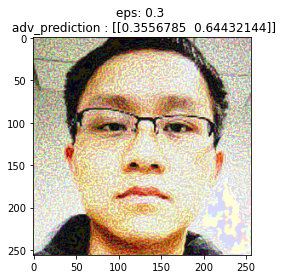

In [18]:
for folder_idx in range(len(features_list)):
    feature = features_list[folder_idx]
    logits = feature['logits']
    if loss_type == 'paper': 
        maps_feature = feature['maps']
        maps_feature = maps_feature[np.newaxis, :]
    if logit_type == 'paper':
        depth_map = feature['depth_map']   
        masks = feature['masks']
        depth_map = depth_map[..., 0] * masks[..., 0]
        depth_mean = np.sum(depth_map) / np.sum(masks[..., 0])
        cla_ratio = flags.paras.cla_ratio
        depth_ratio = 1 - cla_ratio
        logits[label_real] = depth_ratio * depth_mean + cla_ratio * logits[label_real]
        logits[label_spoof] = 1.0 - depth_mean  
        
    folder_names = feature['names'][0].decode()  
    is_test_real = logits[label_real] > logits[label_spoof]
    if is_test_real:
#         with open(os.path.join(result_path, 'logits.txt'), 'a+') as f:
#             f.write(f'folder: {folder_names}\toriginal: {logits}\ttest real\n')
#         n_test_real += 1
        continue 
    label = feature['labels']

    labels_onehot = np.eye(2)[label]

    label = np.array(label)
    label = np.reshape(label,(1,1))

    model_path = export_model_path

    with tf.Session(graph=tf.Graph()) as sess:
        meta_graph_def = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_path)
        signature = meta_graph_def.signature_def
        x_tensor_name = signature['serving_default'].inputs['images'].name
        label_tensor_name = signature['serving_default'].inputs['labels'].name
        if loss_type == 'paper': 
            maps_tensor_name = signature['serving_default'].inputs['maps'].name 
        logit_tensor_name = signature['serving_default'].outputs['logits'].name
        y_tensor_name = signature['serving_default'].outputs['grads'].name
        x = sess.graph.get_tensor_by_name(x_tensor_name)
        y = sess.graph.get_tensor_by_name(y_tensor_name)
        if loss_type == 'paper': 
            maps = sess.graph.get_tensor_by_name(maps_tensor_name)
        labels = sess.graph.get_tensor_by_name(label_tensor_name)
        logits = sess.graph.get_tensor_by_name(logit_tensor_name)
        images_np = np.expand_dims(feature['images'], axis=0)
        logit = sess.run(logits, {x: images_np, labels: label})
        if loss_type == 'paper': 
            grads = sess.run(y, {x: images_np, labels: label, maps: maps_feature})
        elif loss_type == 'CEP':
            grads = sess.run(y, {x: images_np, labels: label})
        
        perb = tf.sign(grads)  # calculate perturbation
        perturbation = perb.eval()
#         plt.title("perturbation:")
#         show(perturbation)
        
        ## Test FGSM ##  
        original_prediction = sess.run(logits, {x: images_np, labels: label})
#         plt.title('original_prediction : {}'.format(original_prediction))
#         show(images_np)
        
#         adv_images = (images_np * 2) + eps * perturbation
#         adv_images = np.clip(adv_images.astype(np.longdouble) / 2, -0.5, 0.5)
#         prediction = sess.run(logits, {x: adv_images})
        display.clear_output(wait=True)

        for i in range(4):
            adv_images = (images_np * 2) + eps[i] * perturbation
            adv_images = np.clip(adv_images.astype(np.longdouble) / 2, -0.5, 0.5)
            prediction = sess.run(logits, {x: adv_images})
            if i == 0:
                plt.title('eps: {} \n original_prediction : {}'.format(eps[i], prediction))
                show(adv_images)
            else:
                plt.title('eps: {} \n adv_prediction : {}'.format(eps[i], prediction))
                show(adv_images)
            plt.pause(2)
            display.clear_output(wait=True)
        
#         if logit_type == 'paper':
#             depth_map_original=feature['depth_map']
#             masks=feature['masks']
#             depth_map_original = depth_map_original[..., 0] * masks[..., 0]
#             depth_mean_original = np.sum(depth_map_original) / np.sum(masks[..., 0])
#             cla_ratio = flags.paras.cla_ratio
#             depth_ratio = 1 - cla_ratio
#             original_prediction[0][label_real] = depth_ratio * depth_mean_original + cla_ratio * original_prediction[0][label_real]
#             original_prediction[0][label_spoof] = 1.0 - depth_mean_original
            
#             depth_map_tensor_name = signature['serving_default'].outputs['depth_map'].name
#             depth_map = sess.graph.get_tensor_by_name(depth_map_tensor_name)
#             depth_map_attack = sess.run(depth_map, {x: adv_images})
#             depth_map_attack = depth_map_attack[..., 0] * masks[..., 0]
#             depth_mean_attack = np.sum(depth_map_attack) / np.sum(masks[..., 0])
#             prediction[0][label_real] = depth_ratio * depth_mean_attack + cla_ratio * prediction[0][label_real]
#             prediction[0][label_spoof] = 1.0 - depth_mean_attack

#     if flags.paras.attack_type == 1:
#         if prediction[0][label_real] >= prediction[0][label_spoof]:
#             print('attack success')
#             n_attack_success += 1
#         else:
#             print('attack fail')
#     elif flags.paras.attack_type == 2:
#         if prediction[0][label_real] > prediction[0][label_spoof]:
#             print('attack success')
#             n_attack_success += 1
#         else:
#             print('attack fail')
#     elif flags.paras.attack_type == 3:
#         if prediction[0][label_real] >= 0.5:
#             print('attack success')
#             n_attack_success += 1
#         else:
#             print('attack fail')
#     elif flags.paras.attack_type == 4:
#         if prediction[0][label_real] > 0.5:
#             print('attack success')
#             n_attack_success += 1
#         else:
#             print('attack fail')
            
#     print("attack success", n_attack_success)
#     print("test_real", n_test_real)
#     print("attack fail", len(features_list) - n_test_real - n_attack_success)
        
#     images_squeeze = np.squeeze(images_np)
#     frames = np.split(images_squeeze, indices_or_sections=5, axis=2)
#     adv_images_squeeze = np.squeeze(adv_images)
#     adv_frames = np.split(adv_images_squeeze, indices_or_sections=5, axis=2)
#     with open(os.path.join(result_path, 'logits.txt'), 'a+') as f:
#         f.write(f'folder: {folder_names}\toriginal: {original_prediction[0]}\tattack: {prediction[0]}\n')

#     if not os.path.exists(f'{result_path}/attack_image/{folder_names}'):
#         os.makedirs(f'{result_path}/attack_image/{folder_names}')

#     for frame_id in range(5):
#         img = np.clip(adv_frames[frame_id] + 0.5, 0, 1)
#         img = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
#         img.save(f'{result_path}/attack_image/{folder_names}/frame_{frame_id + 1}.png')

# if not os.path.exists(os.path.join(result_path, 'attack_result.txt')):
#     os.mknod(os.path.join(result_path, 'attack_result.txt'))
# with open(os.path.join(result_path, 'attack_result.txt'), 'a+') as f:
#     f.write(f'attack type: {flags.paras.attack_type}\n')
#     f.write(f'eps: {eps}\n')
#     f.write(f'attack success rate: {n_attack_success / (len(features_list) - n_test_real)}\tattack success: {n_attack_success}\tattack fail: {len(features_list) - n_test_real - n_attack_success}\ttest real: {n_test_real}\ttotal videos: {len(features_list)}\n')
# print(f'attack success rate: {n_attack_success / (len(features_list) - n_test_real)}\tattack success: {n_attack_success}\tattack fail: {len(features_list) - n_test_real - n_attack_success}\ttest real: {n_test_real}\ttotal videos: {len(features_list)}')